In [1]:
import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import import_ipynb
import keras


# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, backend as K
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

# Scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE


# 1. Configuration des chemins et paramètres
test_dir = r"C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\test"
train_dir =  r"C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train"
test_dir_faux =  r"C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\test_faux"


size_image_x=768
size_image_y=768
input_shape = (size_image_x, size_image_y, 1)

Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4822_mod_2.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4823_add_shadow_effect.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4825_add_shadow_effect.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4825_adjust_brightness_contrast.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4825_skew_image.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Notebooks Python\notebooks\Donnees\train\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4826_mod_1.jpg
Aucun cercle trouvé pour: C:\Users\sauvi\Desktop\Noteboo

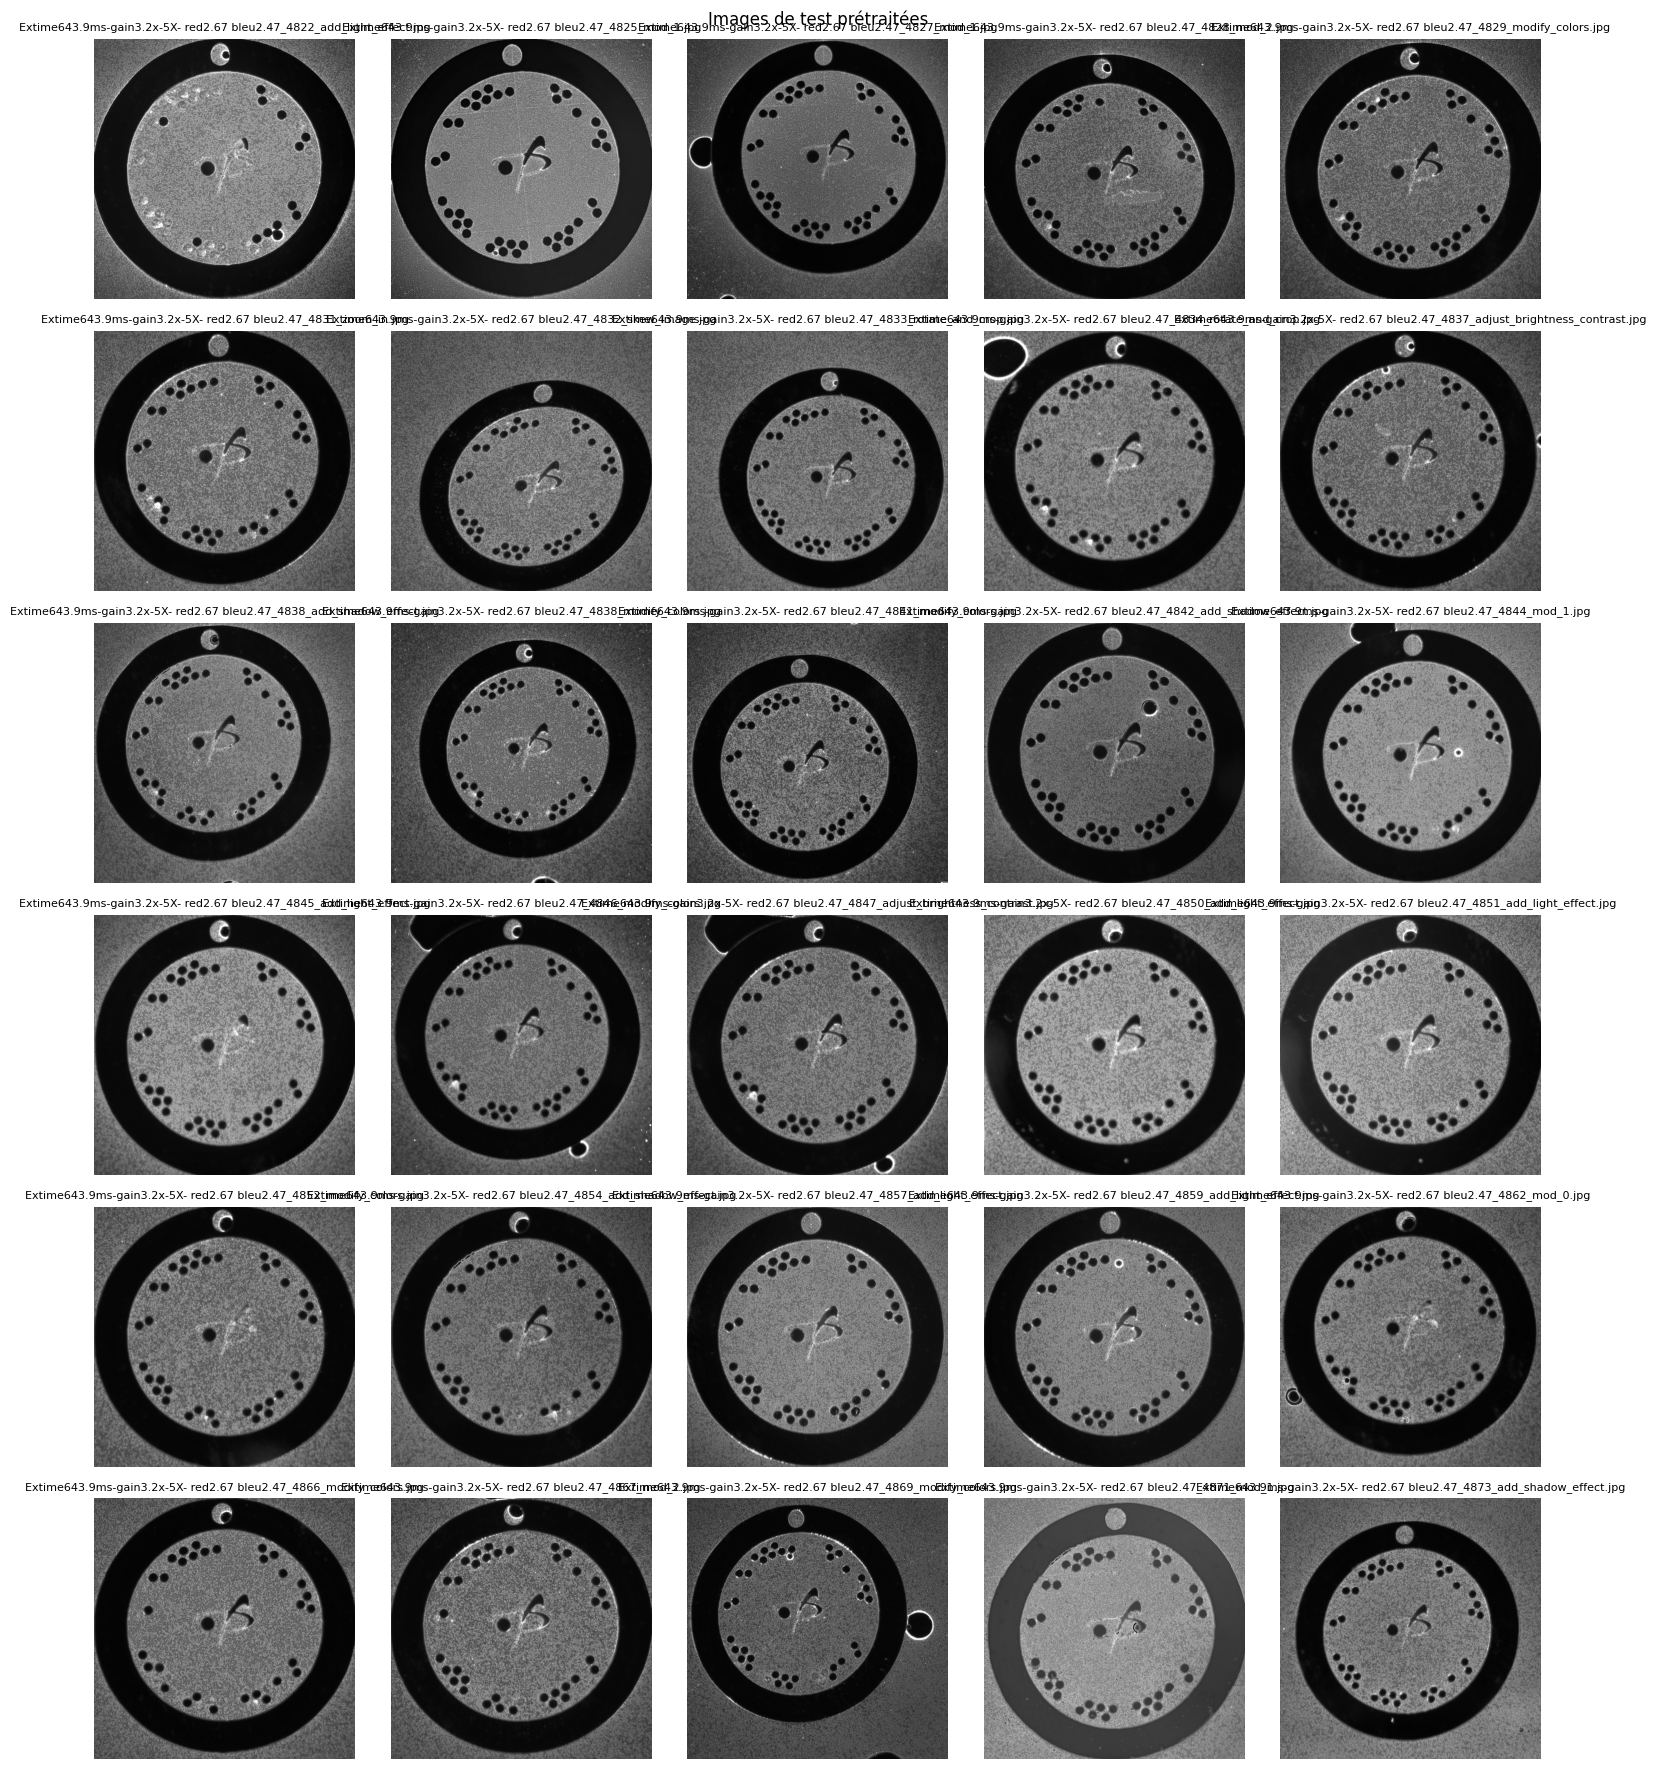

In [2]:
###### Chargement des données ######
resize_width, resize_height = 480, 256
    
def cropped_image(img_path):
    """Charge une image, détecte un cercle, recadre autour (et la convertit en niveaux de gris.)"""
    # Charger l'image
    image0 = cv2.imread(img_path)
    
    if image0 is None:
        print(f"Erreur : Impossible de charger {img_path}")
        return None  # Retourner None au lieu de 'continue'
    
    # Redimensionner l'image à 480x256 pour la détection du cercle
    image = cv2.resize(image0, (resize_width, resize_height))
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Détecter les cercles avec HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300, param1=100, param2=10, minRadius=100, maxRadius=200)

    # Dimensions de l'image redimensionnée
    height, width = gray.shape
    center_x, center_y = width // 2, height // 2

    # Sélectionner le cercle le plus proche du centre, mais uniquement s'il est entièrement visible
    best_circle = None
    min_distance = float("inf")

    if circles is not None:
        for circle in circles[0, :]:
            x, y, r = circle

            # Vérifier que le cercle est entièrement contenu dans l'image
            if (x - r >= 0 and y - r >= 0 and x + r <= width and y + r <= height):
                distance_to_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if distance_to_center < min_distance:
                    min_distance = distance_to_center
                    best_circle = circle
    # Si un cercle a été détecté et validé
    if best_circle is not None:
        x, y, r = best_circle  # Coordonnées du cercle sur l'image redimensionnée

        # Mise à l'échelle des coordonnées et du rayon
        scale_x = image0.shape[1] / resize_width
        scale_y = image0.shape[0] / resize_height
        x = int(x * scale_x)
        y = int(y * scale_y)
        r = int(r * min(scale_x, scale_y))  # Adapter le rayon

        # Définir la taille du carré basé sur le diamètre
        side = 2 * r  

        # Calculer les nouvelles coordonnées pour assurer un carré
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r

        # Vérifier que les coordonnées restent dans les limites de l'image
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image0.shape[1], x2), min(image0.shape[0], y2)

        # Recadrer l'image sur l'image originale
        cropped_image = image0[y1:y2, x1:x2]

        # Convertir en noir et blanc
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return cropped_gray  # Retourner l'image recadrée et en niveaux de gris
    else : 
        print(f"Aucun cercle trouvé pour: {img_path}")
        return None

def load_and_preprocess_images(load_dir, size_image_x, size_image_y):
    """Charge, recadre et prétraite les images de test en niveaux de gris"""
    test_images = []
    valid_file_names = []  # Liste pour stocker les fichiers valides
    test_image_files = [f for f in os.listdir(load_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in test_image_files:
        img_path = os.path.join(load_dir, file)
        try:
            img = cropped_image(img_path)  # Récupérer l'image recadrée
            
            if img is not None:  # Si le recadrage a réussi
                img_resized = Image.fromarray(img).resize((size_image_x, size_image_y))
                img_array = np.array(img_resized) / 255.0  # Normalisation [0,1]
                test_images.append(img_array)
                valid_file_names.append(file)  # Ajouter uniquement si l'image est valide
            
        except Exception as e:
            print(f"❌ Erreur avec l'image {file}: {e}")

    if len(test_images) == 0:
        raise ValueError("❌ Aucune image de test chargée. Vérifiez le dossier des images de test.")

    return np.array(test_images), valid_file_names  # Retourne les noms filtrés



# Chargement des images
train_images, train_image_files = load_and_preprocess_images(train_dir, size_image_x, size_image_y)
test_images, test_image_files = load_and_preprocess_images(test_dir, size_image_x, size_image_y)
test_images_faux, test_image_files_faux = load_and_preprocess_images(test_dir_faux, size_image_x, size_image_y)
print("Test modèle siamois chargé !")

def show_images(images, file_names, title, cols=5):
    num_images = len(images)
    rows = math.ceil(num_images / cols)  # Calcul du nombre de lignes

    plt.figure(figsize=(cols * 3, rows * 3))  # Taille ajustée
    
    for i, (image, file_name) in enumerate(zip(images, file_names)):  
        plt.subplot(rows, cols, i + 1)
        if len(image.shape) == 2:  # Image niveau de gris
            plt.imshow(image, cmap='gray')
        else:  # Image couleur
            plt.imshow(image)
        plt.title(file_name, fontsize=8)
        plt.axis("off")

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
# Afficher les images de test avec une grille plus lisible
show_images(test_images, test_image_files, "Images de test prétraitées")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 768, 768, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 768, 768, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 384, 384, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 384, 384, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 192, 192, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 192, 192, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96, 96, 32)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,888 (23.00 KB)

 Trainable params: 5,888 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 192, 192, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 192, 192, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 384, 384, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 384, 384, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 768, 768, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 768, 768, 1)         │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 15,105 (59.00 KB)

 Non-trainable params: 0 (0.00 B)

✅ Train modifiées: (357, 768, 768)
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 562ms/step - accuracy: 9.0396e-06 - loss: 0.0607 - val_accuracy: 5.6490e-05 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 9.1730e-06 - loss: 0.0100 - val_accuracy: 5.8162e-05 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 5.5816e-05 - loss: 0.0074 - val_accuracy: 1.4818e-04 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - accuracy: 1.1675e-04 - loss: 0.0053 - val_accuracy: 1.5122e-04 - val_loss: 0.0049 - learning_rate: 0.0010


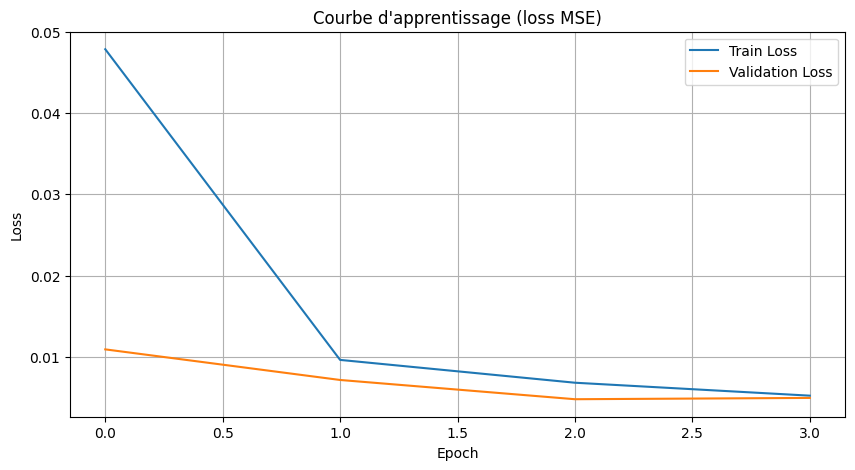

In [4]:
###### Autoencodeur ######
# Définir l'architecture de l'autoencodeur
inputs = keras.Input(shape=(size_image_y, size_image_x, 1))

# Charger le modèle VGG16 pour la perte perceptuelle
vgg = VGG16(include_top=False, weights=None, input_shape=(size_image_y, size_image_x, 1))
vgg.trainable = False

"""
# Fonction pour calculer la perte perceptuelle
def perceptual_loss(y_true, y_pred):
    y_true_resized = tf.image.resize(y_true, (size_image_y, size_image_x))
    y_pred_resized = tf.image.resize(y_pred, (size_image_y, size_image_x))
    
    y_true_resized = tf.reduce_mean(y_true_resized, axis=-1, keepdims=True)
    y_pred_resized = tf.reduce_mean(y_pred_resized, axis=-1, keepdims=True)
    # Convertir les images en RGB (si elles sont en niveaux de gris)
    y_true_3c = tf.image.grayscale_to_rgb(y_true_resized)
    y_pred_3c = tf.image.grayscale_to_rgb(y_pred_resized)
    
    # Passer les images dans le modèle VGG16 pour obtenir les caractéristiques
    y_true_features = vgg(y_true_3c)
    y_pred_features = vgg(y_pred_3c)
    
    # Retourner la différence entre les caractéristiques
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

# Combiner perceptual_loss et MSE
def hybrid_loss(y_true, y_pred):
    perceptual = perceptual_loss(y_true, y_pred)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return perceptual + mse

# 5. Perte contrastive
def contrastive_loss(y_true, y_pred, margin=1):
    return K.mean(
        y_true * K.square(y_pred) +
        (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))
    )
"""
latent_dim = 10

# Encoder
x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(inputs)
#layers.BatchNormalization(),
x = layers.MaxPooling2D((2,2), padding='same')(x)
#x = layers.Dropout(0.2)(x)  # Ajout de Dropout pour éviter le surapprentissage
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
#layers.BatchNormalization(),
x = layers.MaxPooling2D((2,2), padding='same')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
#layers.BatchNormalization(),
x = layers.MaxPooling2D((2,2), padding='same')(x)
z = layers.Dropout(0.5)(x)
"""
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
#layers.BatchNormalization(),
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Dropout(0.5)(x)
"""
"""
x = layers.Flatten()(x)
x = layers.Dense(16, activation = "relu")(x)
z = layers.Dense(latent_dim)(x)
"""
encoder = keras.Model(inputs, z, name ="encoder")
encoder.summary()

#bottleneck
#x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
#x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
"""
# Decoder
decod = keras.Input(shape=(latent_dim,))  # Entrée avec les bonnes dimensions
x = layers.Dense(32 * 60 * 128, activation = "relu")(decod)
x = layers.Reshape((32, 60, 128))(x)
"""
#decod=keras.Input(shape=(96, 96, 32))
decod = keras.Input(shape=(size_image_y // 8, size_image_x // 8, 32))
"""
x = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
#layers.BatchNormalization(),

"""
x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(decod)
#layers.BatchNormalization(),
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
#layers.BatchNormalization(),
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
#layers.BatchNormalization(),
outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Sortie : Une image de même taille que l'entrée

decoder = keras.Model(decod, outputs, name = "decoder")
decoder.summary()

#inputs = keras.Input(shape=(size_image_y, size_image_x, 3))

latents = encoder(inputs)
outputs = decoder(latents)

ae = keras.Model(inputs, outputs, name = "ae")
ae.summary

# Compiler le modèle
#ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mse', metrics=['accuracy'])
ae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=0.1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=0.1, min_lr=0.1)

#train the model
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=0.1, min_lr=0.1),
             keras.callbacks.TensorBoard(histogram_freq=1), keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.1, restore_best_weights=True)
]

print(f"✅ Train modifiées: {train_images.shape}")

# Entraîner le modèle sur les paires d'images
history = ae.fit(
    train_images, train_images,
    epochs=10,
    batch_size=8,
    verbose = 1,
    validation_split=0.2,  
    #validation_data = (train_images_modifiees, train_images_originales),
    callbacks = callbacks
)

ae.save("ae_model.keras")

# Courbes d'apprentissage
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe d\'apprentissage (loss MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ test_images shape : (30, 768, 768)
✅ Type: <class 'numpy.ndarray'>


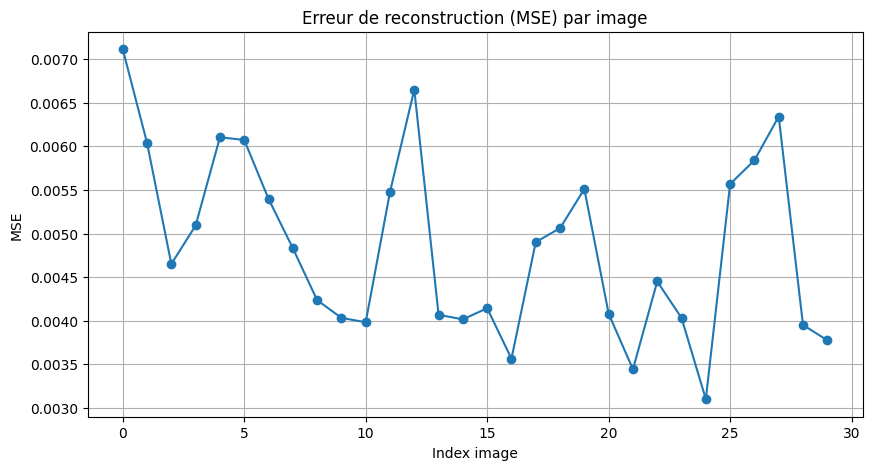

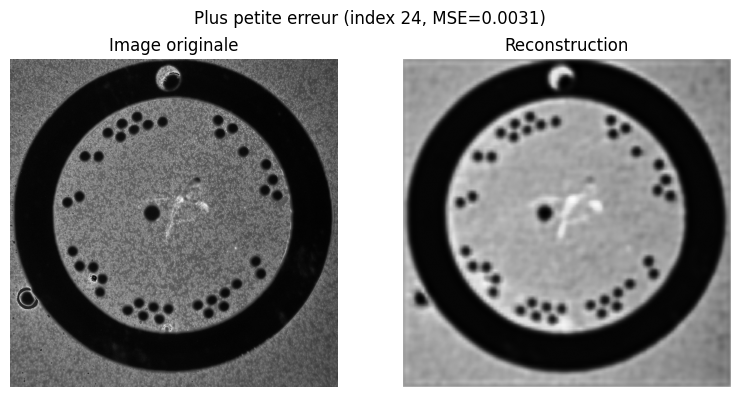

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
✅ Latent vectors shape : (1, 96, 96, 32)


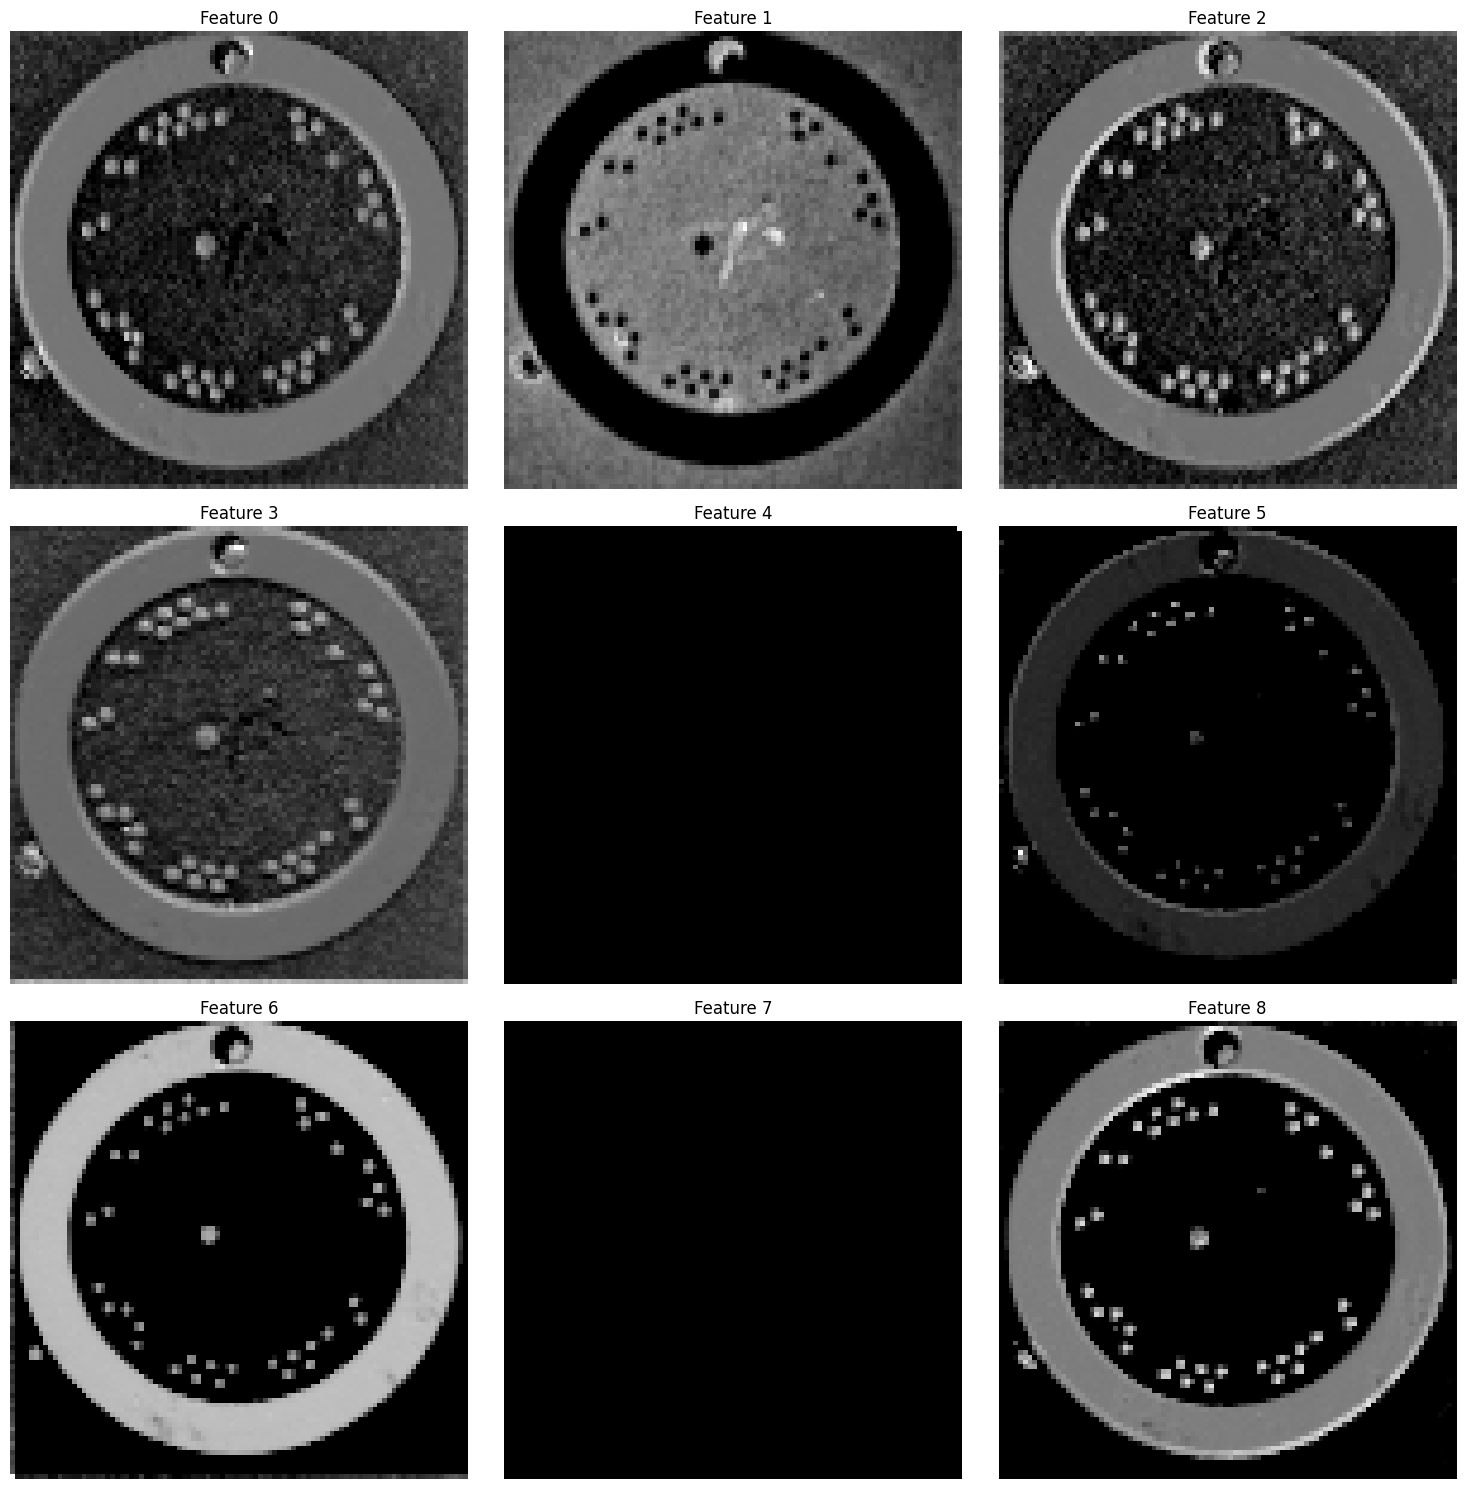

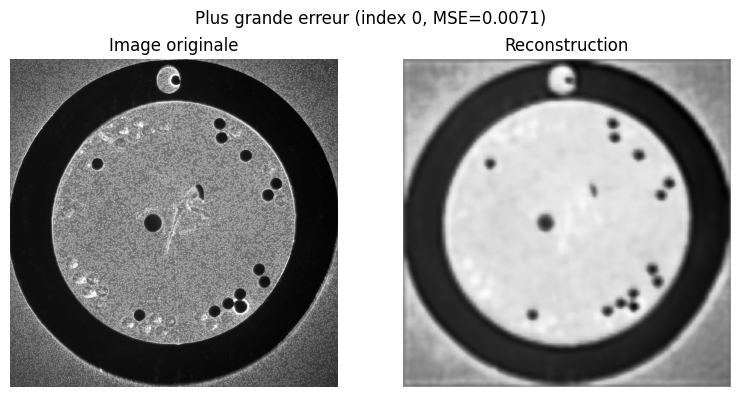

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
✅ Latent vectors shape : (1, 96, 96, 32)


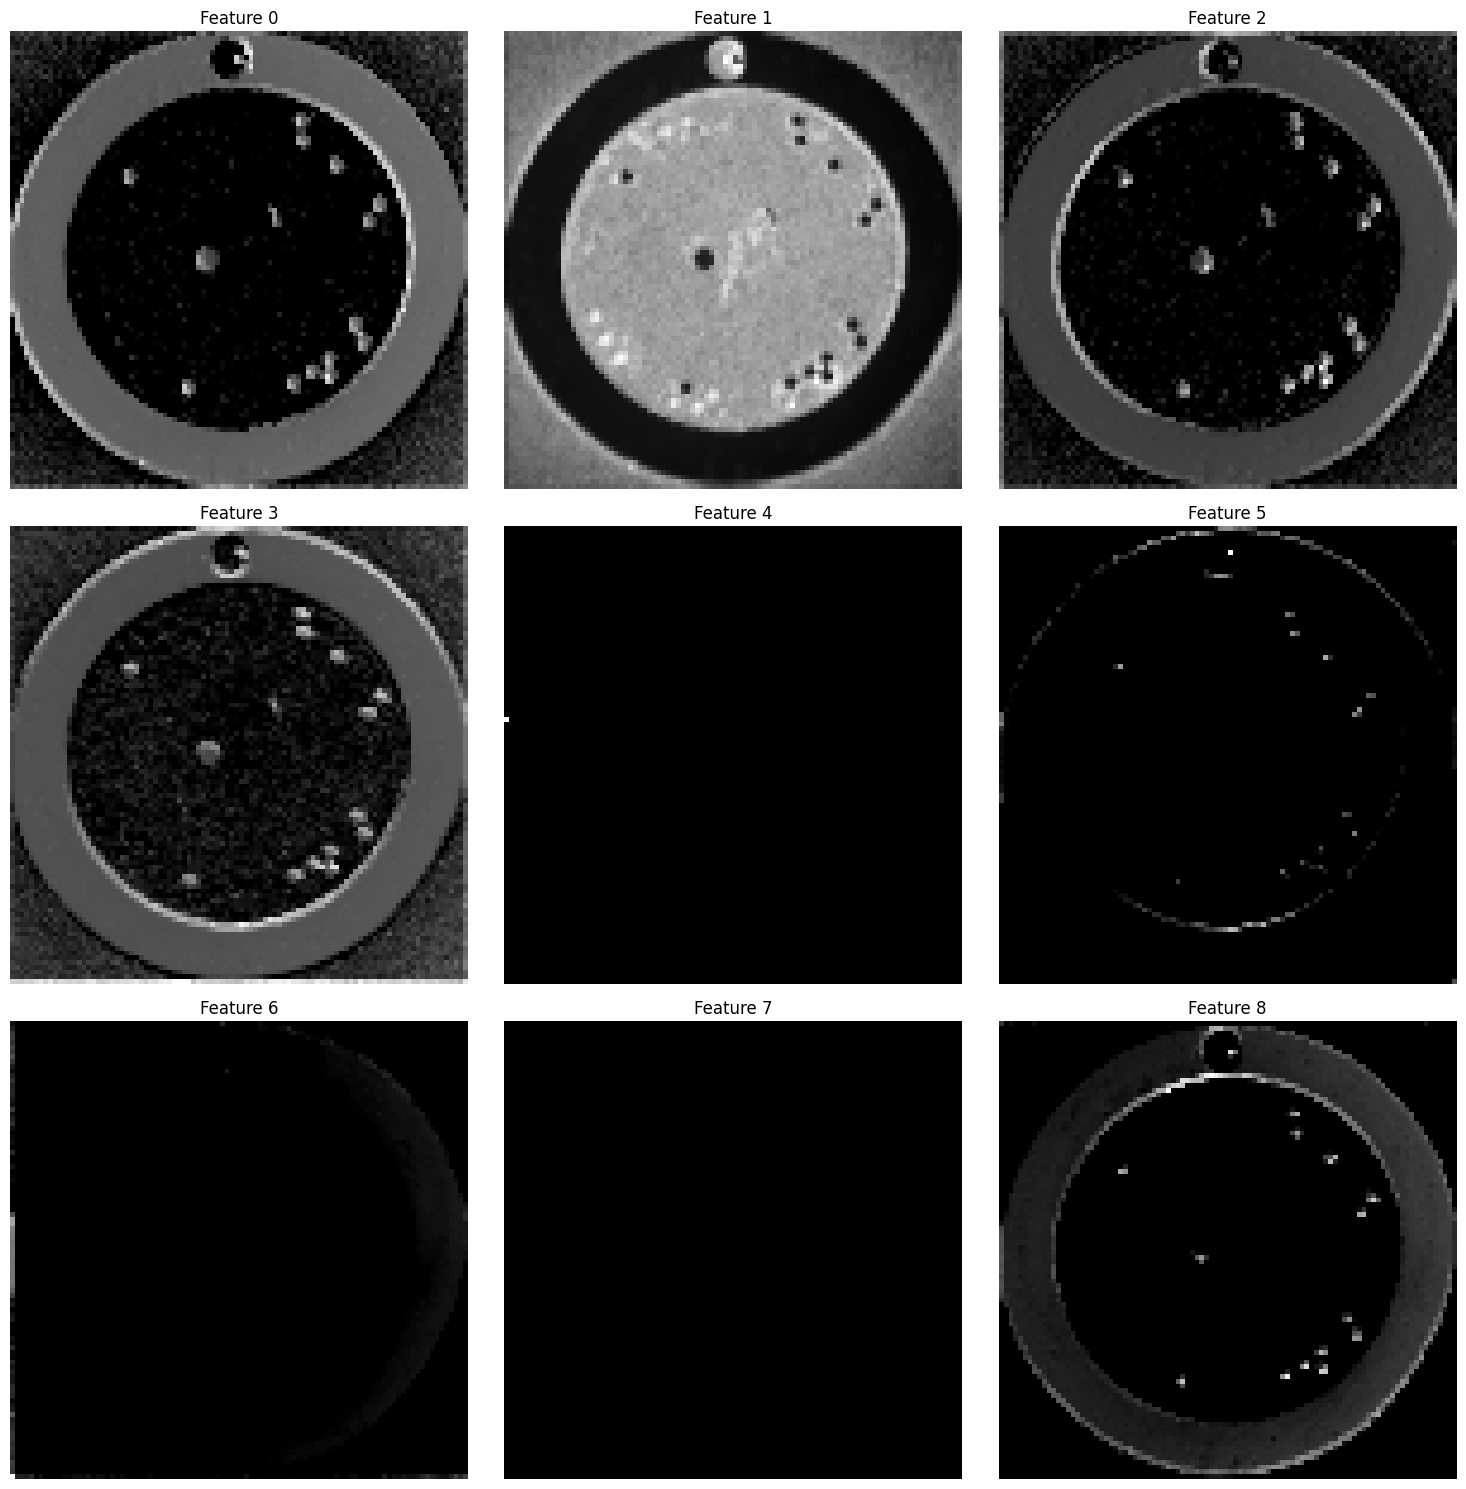

In [5]:
#################################
###### Test de validation des performances ###### 
reconstructed_images = ae.predict(test_images)
print("✅ test_images shape :", test_images.shape)
print("✅ Type:", type(test_images))

### Erreur de reconstruction
errors = []
for orig, recon in zip(test_images, reconstructed_images):
    error = mean_squared_error(orig.flatten(), recon.flatten())
    errors.append(error)

plt.figure(figsize=(10,5))
plt.plot(errors, marker='o')
plt.title("Erreur de reconstruction (MSE) par image")
plt.xlabel("Index image")
plt.ylabel("MSE")
plt.grid(True)
plt.show()



# Afficher les cas d'erreur min et max
min_error_index = np.argmin(errors)
max_error_index = np.argmax(errors)
for label, index in zip(["Plus petite erreur", "Plus grande erreur"], [min_error_index, max_error_index]):
    original = test_images[index]
    reconstructed = reconstructed_images[index]

    plt.figure(figsize=(8,4))
    plt.suptitle(f"{label} (index {index}, MSE={errors[index]:.4f})", fontsize=12)

    plt.subplot(1,2,1)
    plt.imshow(original, cmap="gray")
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(reconstructed, cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


    ### Visualisation du bottleneck
    latent_representation = encoder.predict(np.expand_dims(original, axis=0))
    print("✅ Latent vectors shape :", latent_representation.shape)

    if len(latent_representation.shape) == 4:
        latent_representation = np.squeeze(latent_representation)
        num_filters = latent_representation.shape[-1]

        num_cols = 3
        num_rows = int(np.ceil((min(num_filters, 8) + 1) / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

        for i in range(min(num_filters, 9)):
            row, col = divmod(i, num_cols)
            axes[row, col].imshow(latent_representation[:, :, i], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Feature {i}")

        for i in range(min(num_filters, 9) + 1, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
✅ test_images shape : (21, 768, 768)
✅ Type: <class 'numpy.ndarray'>


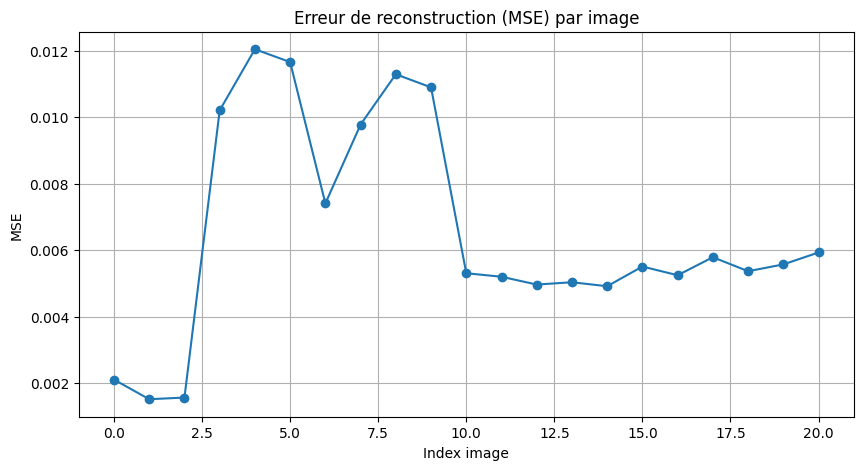

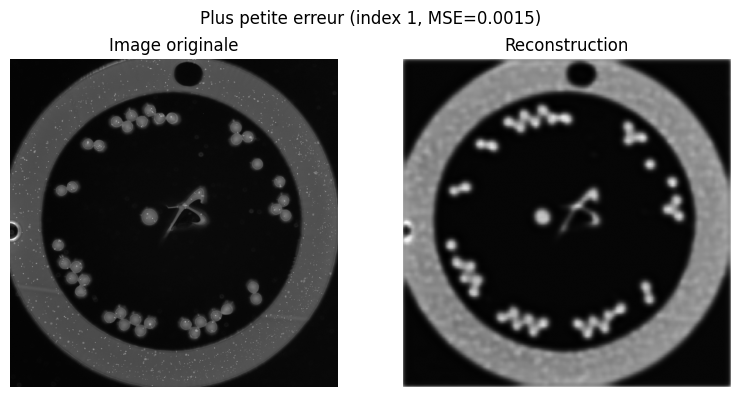

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
✅ Latent vectors shape : (1, 96, 96, 32)


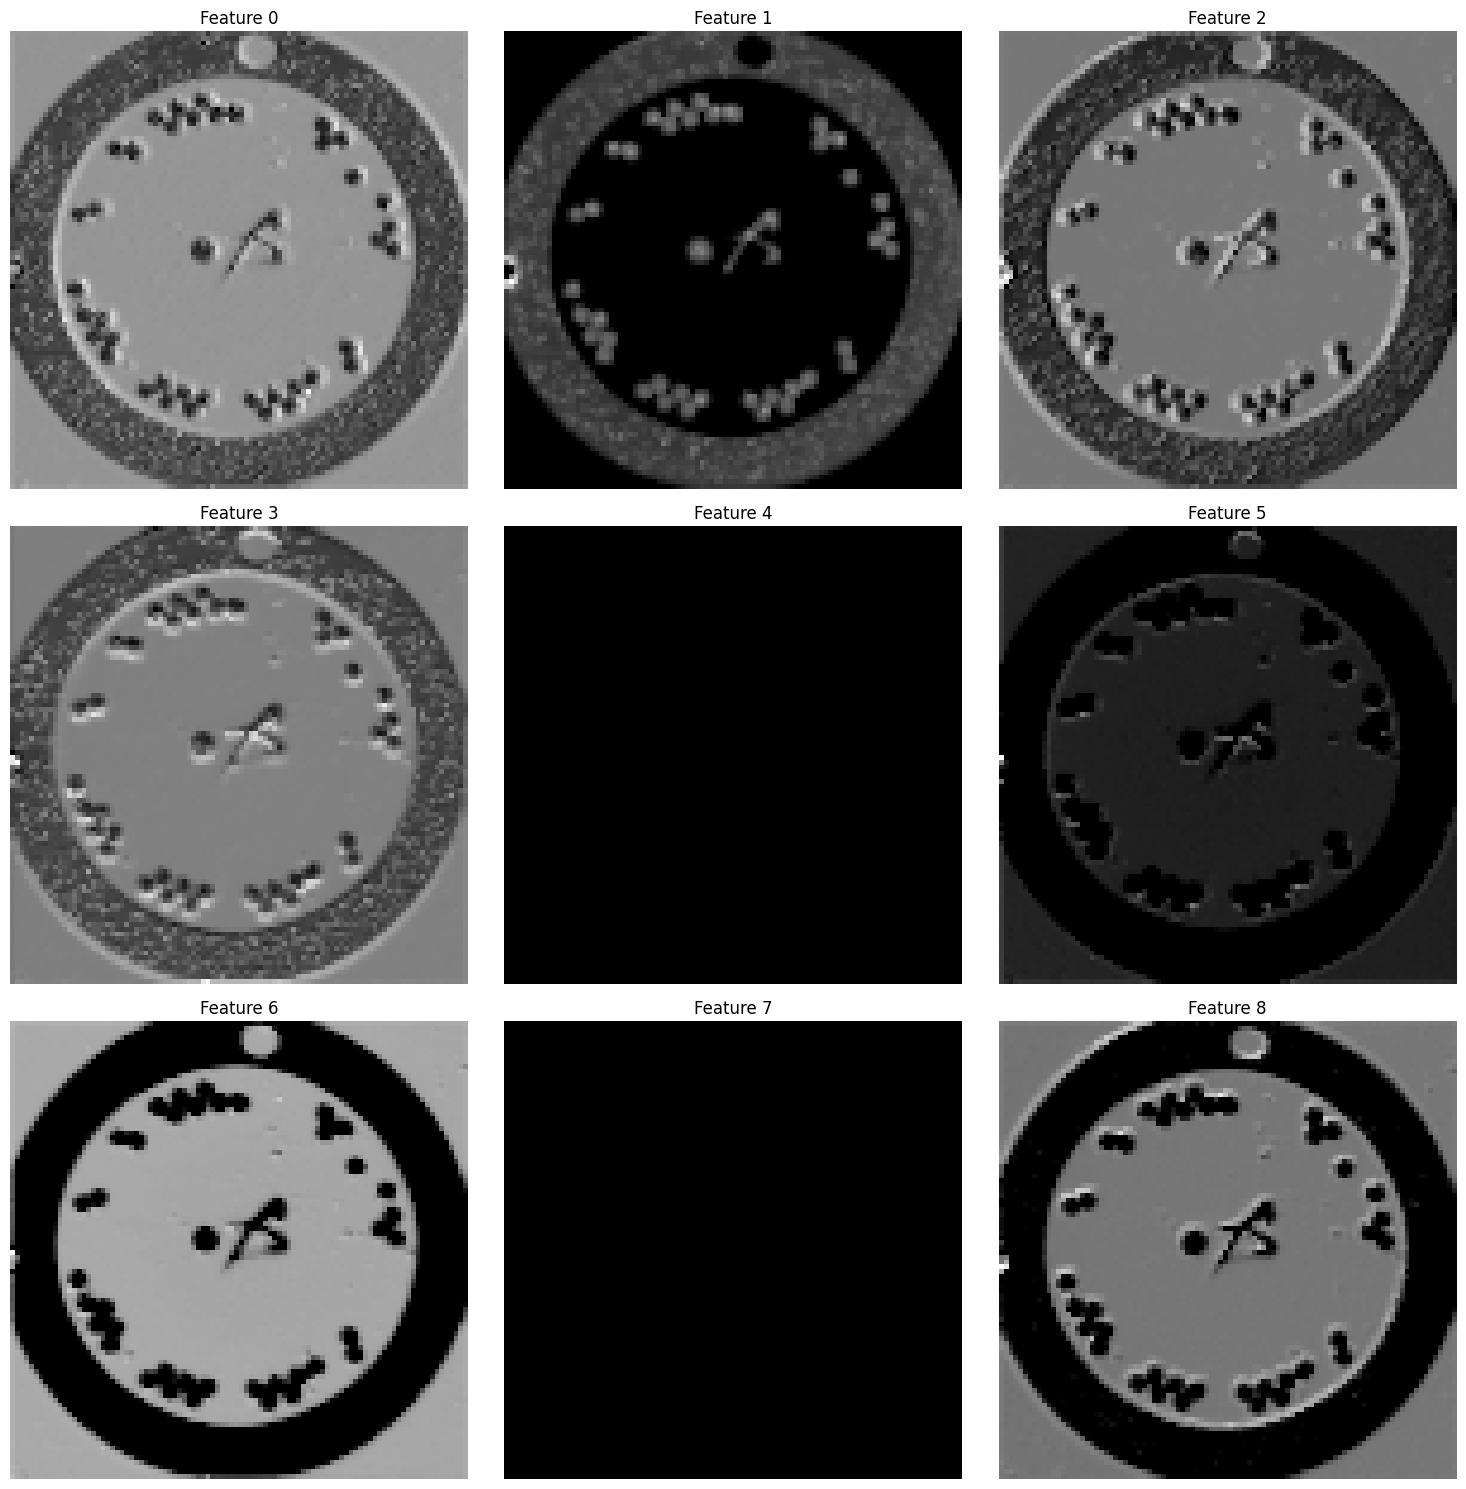

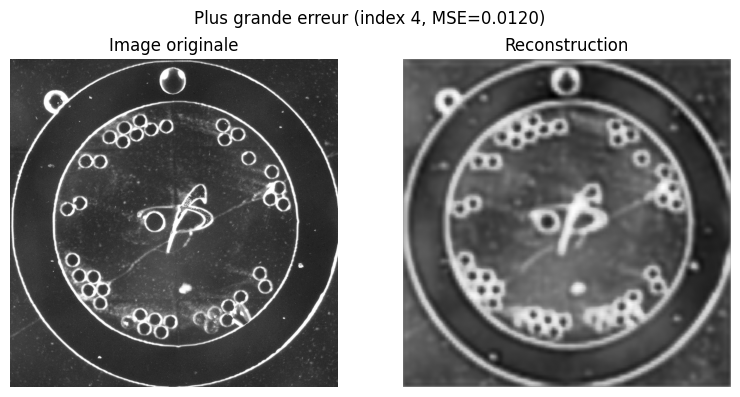

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
✅ Latent vectors shape : (1, 96, 96, 32)


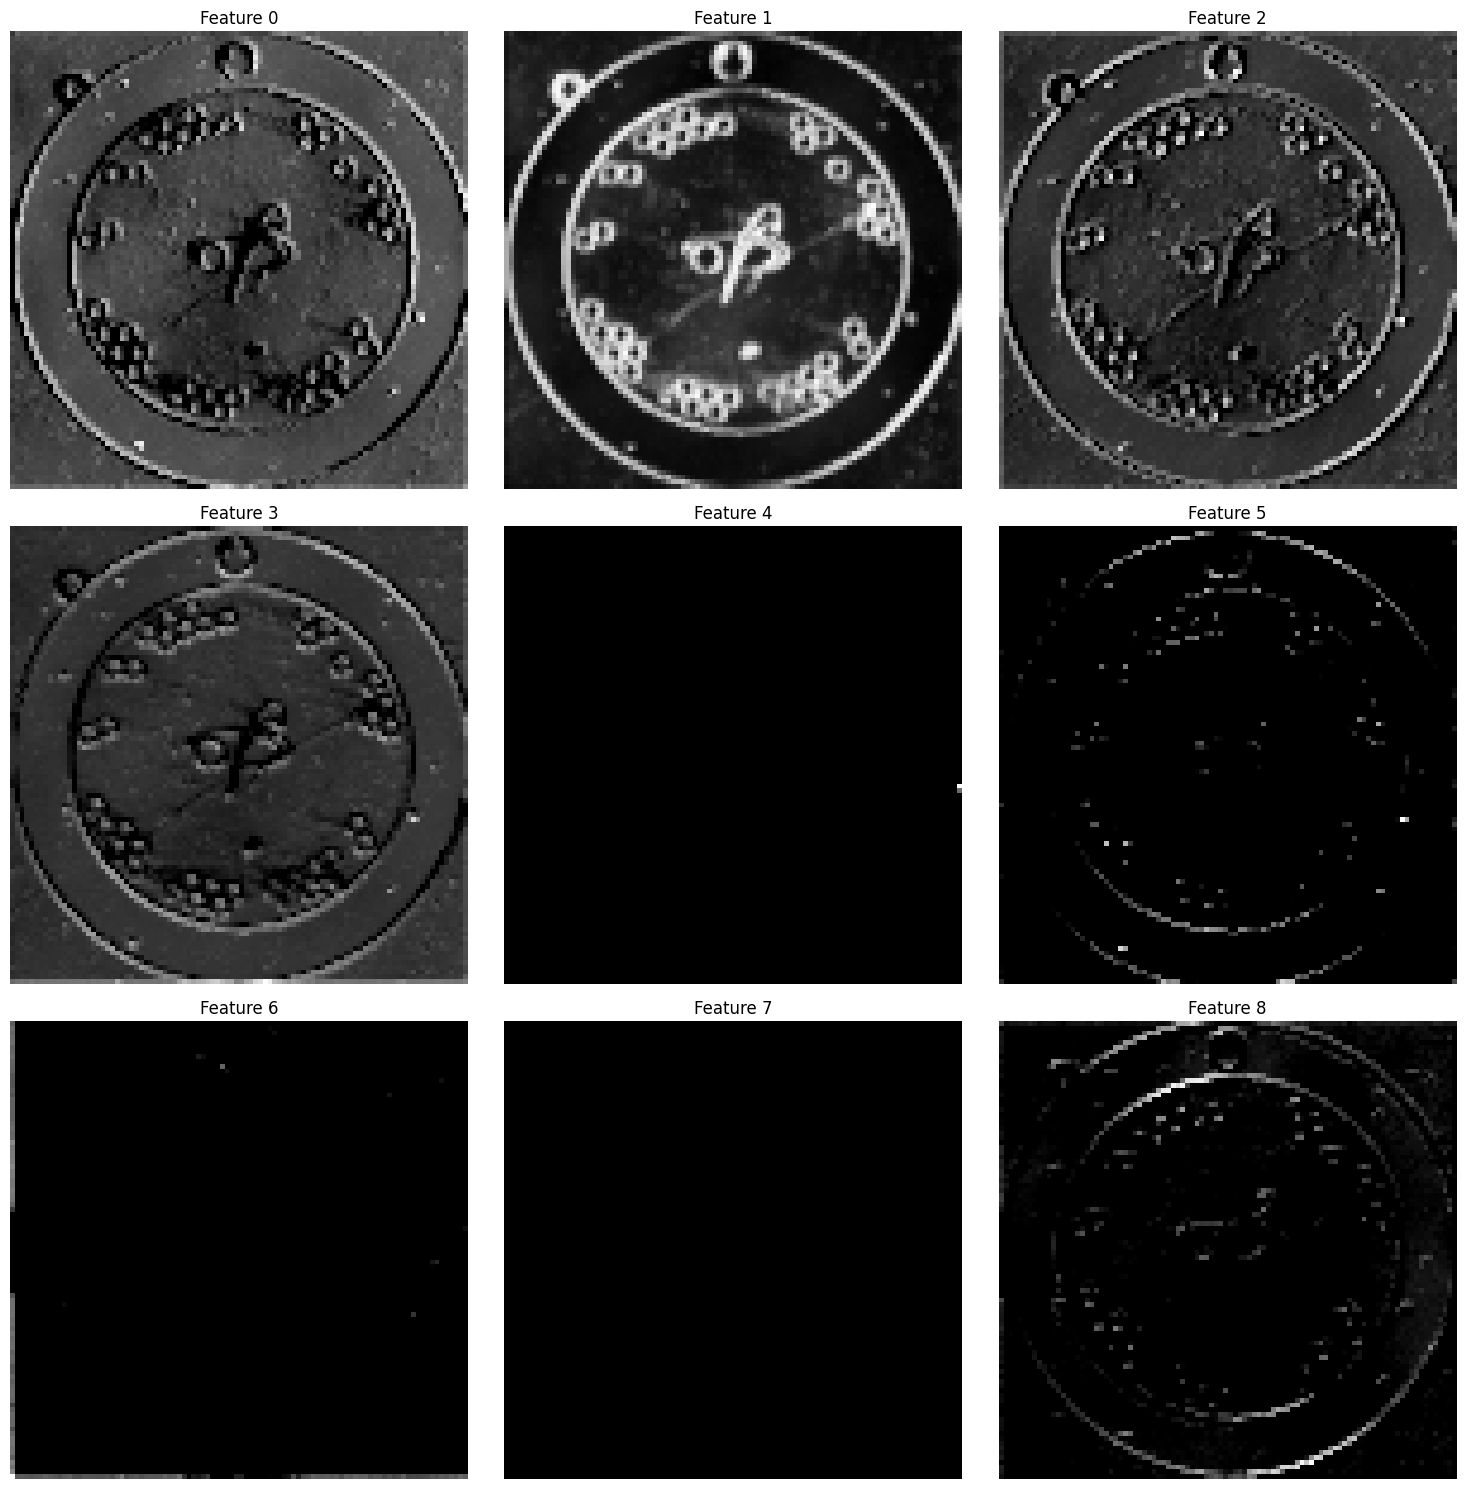

In [6]:
#################################
###### Test de validation des performances sur des iamges d'un autre type (autre résine ou support) ###### 
reconstructed_images_faux = ae.predict(test_images_faux)
print("✅ test_images shape :", test_images_faux.shape)
print("✅ Type:", type(test_images_faux))

### Erreur de reconstruction
errors = []
for orig, recon in zip(test_images_faux, reconstructed_images_faux):
    error = mean_squared_error(orig.flatten(), recon.flatten())
    errors.append(error)

plt.figure(figsize=(10,5))
plt.plot(errors, marker='o')
plt.title("Erreur de reconstruction (MSE) par image")
plt.xlabel("Index image")
plt.ylabel("MSE")
plt.grid(True)
plt.show()



# Afficher les cas d'erreur min et max
min_error_index = np.argmin(errors)
max_error_index = np.argmax(errors)
for label, index in zip(["Plus petite erreur", "Plus grande erreur"], [min_error_index, max_error_index]):
    original = test_images_faux[index]
    reconstructed = reconstructed_images_faux[index]

    plt.figure(figsize=(8,4))
    plt.suptitle(f"{label} (index {index}, MSE={errors[index]:.4f})", fontsize=12)

    plt.subplot(1,2,1)
    plt.imshow(original, cmap="gray")
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(reconstructed, cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


    ### Visualisation du bottleneck
    latent_representation_faux = encoder.predict(np.expand_dims(original, axis=0))
    print("✅ Latent vectors shape :", latent_representation_faux.shape)

    if len(latent_representation_faux.shape) == 4:
        latent_representation_faux = np.squeeze(latent_representation_faux)
        num_filters = latent_representation_faux.shape[-1]

        num_cols = 3
        num_rows = int(np.ceil((min(num_filters, 8) + 1) / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

        for i in range(min(num_filters, 9)):
            row, col = divmod(i, num_cols)
            axes[row, col].imshow(latent_representation_faux[:, :, i], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Feature {i}")

        for i in range(min(num_filters, 9) + 1, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


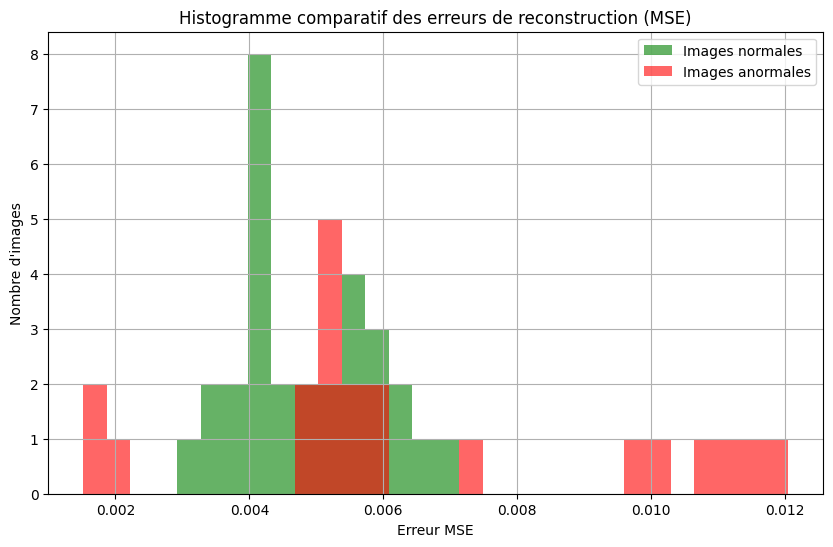

In [8]:
# 1. Reconstruction
test_images_pred = ae.predict(test_images)
test_images_faux_pred = ae.predict(test_images_faux)

# 2. Calcul des erreurs MSE
mse_test = np.mean(np.square(np.expand_dims(test_images, -1) - test_images_pred), axis=(1,2,3))
mse_faux = np.mean(np.square(np.expand_dims(test_images_faux, -1) - test_images_faux_pred), axis=(1,2,3))

# 3. Créer des bins communs (ex : 30 bins entre le min et le max global)
all_errors = np.concatenate([mse_test, mse_faux])
bin_edges = np.linspace(all_errors.min(), all_errors.max(), 31)  # 30 bins

# 4. Tracer l'histogramme superposé
plt.figure(figsize=(10,6))
plt.hist(mse_test, bins=bin_edges, alpha=0.6, color='green', label='Images normales')
plt.hist(mse_faux, bins=bin_edges, alpha=0.6, color='red', label='Images anormales')
plt.title("Histogramme comparatif des erreurs de reconstruction (MSE)")
plt.xlabel("Erreur MSE")
plt.ylabel("Nombre d'images")
plt.legend()
plt.grid(True)
plt.show()
